In [1]:
import numpy as np
import pandas as pd

## The init function.

This gets our data into a clean dataframe! We also have various helping auxilliary functions allowing us to add columns if we so choose

* prs: how many periods we want to take as input
* growths: Adds a column for every period telling us how much a post a post has grown
* opp: Flag whether a post is in an opportune window, that is, the age of the current top post is greater than opp (in hours). The logic here is that reddit posts are more likely to succesful when the current top post is old.  
* days: one hot vector for day of week
* hours: one hot vector for hour
* feats: whether to include features of the post like word length, sentence length, total length
* clas: Whether we want it to be a classification problem
    * thresh: the cutoff for a succesful post

In [6]:


def init(prs, thresh, yName = "finalScore", opp = 12, growths = True, days = False, hours = False, feats = False, clas = False):
    #importing and preprocessing
    from sklearn.model_selection import cross_val_score
    data = pd.read_csv(r'MLfile.csv')
    data.head()
    data["constant"] = 1
    data = data.drop(columns = ["maxscore"])
    data = data.drop(columns = ["age", 'created1.1', 'score1.1', 'age1.1', 'stories1.1', 'ratio1.1', 'coms1.1', 'created2.1', 'score2.1', 'age2.1', 'stories2.1', 'ratio2.1', 'coms2.1', 'created3.1', 'score3.1', 'age3.1', 'stories3.1', 'ratio3.1', 'coms3.1', 'created4.1', 'score4.1', 'age4.1', 'stories4.1', 'ratio4.1', 'coms4.1', 'created5.1', 'score5.1', 'age5.1', 'stories5.1', 'ratio5.1', 'coms5.1'])
    data["finalScore"] = data["61selfScore"]
    data["success"] = 0
    from sklearn.utils import shuffle
    #data = shuffle(data)
    #getHour and decide whether o not to shuffle
    import datetime
    def getHourIndex(pers, intercept = 37, slope = 34):
        return(intercept + 34*pers)

    threshL = [thresh]
    pers = prs
    ind = getHourIndex(pers)

    curr = 1
    for x in threshL:
        data.loc[data.finalScore > x, "success"] = curr
        curr += 1
    
    ##data.loc[data.finalScore > thresh, "success"] = 1
    X = data[data.columns[3:ind]]
    y = data[yName]
    cands = []
    for name in X.columns:
        if "selfScore" in name:
            cands.append(name)
    if(growths):
        cnt = 1
        while cnt < len(cands):
            curr = cands[cnt]
            prev = cands[cnt - 1]
            nd = str(cnt) + "diffGrowth"
            nm = str(cnt) + "multGrowth"
            X[nd] = X[curr] - X[prev]
            X["custom"] = X[prev]
            X["custom"] = X["custom"].replace(0,1)
            X[nm] = X[curr] / X["custom"]
            cnt += 1
        X = X.drop(columns = ["custom"])
    if days:
        X = pd.concat([X, data["created_utc"].apply(lambda s: pd.Series({'day':datetime.datetime.utcfromtimestamp(s).strftime('%a')}))], axis=1)
        t = pd.get_dummies(X["day"])
        X = X.join(t)
        X = X.drop(columns = ["day"])
    if hours:
        X = pd.concat([X, data["created_utc"].apply(lambda s: pd.Series({'hour':datetime.datetime.utcfromtimestamp(s).strftime('%H')}))], axis=1)
        t = pd.get_dummies(X["hour"])
        X = X.join(t)
        X = X.drop(columns = ["hour"])
    if feats:
        X["sentences"] = data["title"].str.count(".")
        X["words"] = data["title"].str.count(" ") + 1
        X["length"] = data["title"].str.len()
        X["wordLength"] = X["length"]/X["words"]
    if opp != 0:
        X["timed"] = 0
        X.loc[X["age1"] > opp, "timed"] = 1
    X = X.apply(pd.to_numeric)
    if(clas):
        y = data["success"]
    return(X,y)

## Let's focus on 6 periods - 2 hours. Let's have all the dummies.  

In [7]:
obj = init(6, 2000, growths = True, feats = True, days = True, opp = 13)

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Viral Shanker\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Viral Shanker\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [8]:
X = obj[0]
y = obj[1]
obj[0]

,observation#,created1,score1,age1,stories1,ratio1,coms1,created2,score2,age2,...,Sat,Sun,Thu,Tue,Wed,sentences,words,length,wordLength,timed
0,61,1563071823,744,4.193253,3,0.98,13,1563072528,458,3.997654,...,0,1,0,0,0,78,14,78,5.571429,0
1,61,1563071823,875,4.516081,3,0.98,13,1563072528,547,4.320538,...,0,1,0,0,0,125,23,125,5.434783,0
2,61,1563071823,1023,4.849477,3,0.98,14,1563072528,610,4.653943,...,0,1,0,0,0,184,36,184,5.111111,0
3,61,1563071823,1275,5.516044,4,0.98,17,1563072528,729,5.320512,...,0,1,0,0,0,150,28,150,5.357143,0
4,61,1563071823,1404,5.849266,5,0.98,18,1563072528,783,5.653728,...,0,1,0,0,0,173,31,173,5.580645,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38016,61,1578087121,10282,8.983557,7,0.95,109,1578039856,6592,22.114098,...,1,0,0,0,0,283,52,283,5.442308,0
38017,61,1578087121,10282,8.983557,7,0.95,109,1578039856,6592,22.114098,...,1,0,0,0,0,93,14,93,6.642857,0
38018,61,1578087121,10282,8.983557,7,0.95,109,1578039856,6592,22.114098,...,1,0,0,0,0,124,24,124,5.166667,0
38019,61,1578087121,10551,9.317151,7,0.95,111,1578039856,6595,22.447526,...,1,0,0,0,0,293,50,293,5.860000,0


## Basic Regression

Alright! We have our data! Let's try a really basic OLS regression

In [9]:
from linearmodels import OLS
import statsmodels.api as sm

## We must drop a day dummy to avoid the cummy variable trap

In [10]:
X = X.drop(columns = "Mon")

In [11]:
reg = sm.OLS(y, X[X.columns[2:]]).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             finalScore   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     125.7
Date:                Sun, 05 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:54:56   Log-Likelihood:            -2.9608e+05
No. Observations:               38021   AIC:                         5.926e+05
Df Residuals:                   37796   BIC:                         5.945e+05
Df Model:                         224                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
score1              0.0237      0.012      1.917      0.055      -0.001       0.048
age1              -13.6826      4.907     -2.788      0.005     -23.301      -4.064
stories1            1.5021      2.379      0.631      0.528      -3.162       6.166
ratio1           -344.6899    629.254     -0.548      0.584   -1578.045     888.665
coms1               0.3708      0.467      0.793      0.428      -0.545       1.287
created2           -1.2217     10.838     -0.113      0.910     -22.465      20.022
score2              0.0202      0.010      1.993      0.046       0.000       0.040
age2            -4406.2686    3.9e+04     -0.113      0.910   -8.09e+04    7.21e+04
stories2            0.3693      2.226      0.166      0.868      -3.994       4.733
ratio2           -386.8632    394.609     -0.980      0.327   -1160.308     386.582
coms2               0.1930      0.427      0.452      0.651      -0.643       1.030
created3           -0.6030     17.333     -0.035      0.972     -34.577      33.371
score3              0.0203      0.009      2.383      0.017       0.004       0.037
age3            -2174.9108   6.24e+04     -0.035      0.972   -1.24e+05     1.2e+05
stories3           -0.7744      2.139     -0.362      0.717      -4.967       3.418
ratio3           -471.7397    271.768     -1.736      0.083   -1004.412      60.933
coms3              -0.2280      0.366     -0.624      0.533      -0.945       0.489
created4            5.2649     14.149      0.372      0.710     -22.468      32.997
score4              0.0160      0.007      2.324      0.020       0.003       0.030
age4             1.895e+04   5.09e+04      0.372      0.710   -8.09e+04    1.19e+05
stories4           -0.7290      1.899     -0.384      0.701      -4.451       2.993
ratio4            553.5234    212.544      2.604      0.009     136.931     970.116
coms4               0.0554      0.309      0.179      0.858      -0.550       0.661
created5           -3.4267      8.611     -0.398      0.691     -20.305      13.452
score5              0.0110      0.005      2.221      0.026       0.001       0.021
age5            -1.234e+04    3.1e+04     -0.398      0.691   -7.31e+04    4.84e+04
stories5           -0.7717      1.390     -0.555      0.579      -3.497       1.953
ratio5             62.7637    163.596      0.384      0.701    -257.889     383.416
coms5              -0.1866      0.220     -0.849      0.396      -0.617       0.244
score             -38.2401      3.345    -11.432      0.000     -44.796     -31.684
numberstories     -65.6341     23.523     -2.790      0.005    -111.740     -19.528
upvoteratio       121.6177     35.128      3.462      0.001      52.766     190.470
num_coms           51.7998     16.135      3.210      0.001      20.176      83.424
1selfScore         -2.5767      2.866     -0.899      0.369

#### Decent, but not too impressive

An R^2 of 0.427 is fine enough, but given the information we have, we can do better. 

## Sklearn models

Let's try machine learning! Surely we can do better than the default regression. 

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=829)

## Gradient Boosting

generally, the best, "out of the box" model we have, gradient boosters. First we try with standard parameters. 

## Visualizing training

      Iter       Train Loss   Remaining Time 
         1      581249.7069            1.27m
         2      575081.1133            1.29m
         3      569034.6785            1.34m
         4      563105.1208            1.35m
         5      557292.9990            1.33m
         6      551593.1816            1.33m
         7      546031.6281            1.32m
         8      540547.4359            1.31m
         9      535168.9994            1.30m
        10      529913.2898            1.31m
        20      482293.1871            1.26m
        30      442680.4858            1.23m
        40      409770.6145            1.20m
        50      381799.9603            1.18m
        60      358343.6479            1.16m
        70      338405.1374            1.15m
        80      321259.7817            1.13m
        90      306141.0399            1.11m
       100      293577.0023            1.09m
       200      231554.3586           52.38s
       300      212025.9188           39.14s
       40

Text(0,0.5,'Deviance')

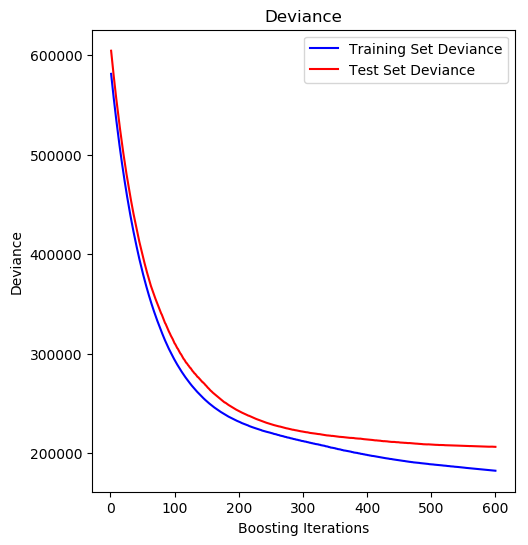

In [58]:
params = {'n_estimators': 600, 'max_depth': 2, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Interpreting Our results

### We see clear decreases in loss in both training and test sets, telling us that we are not overfitting. Let's see the feature importances

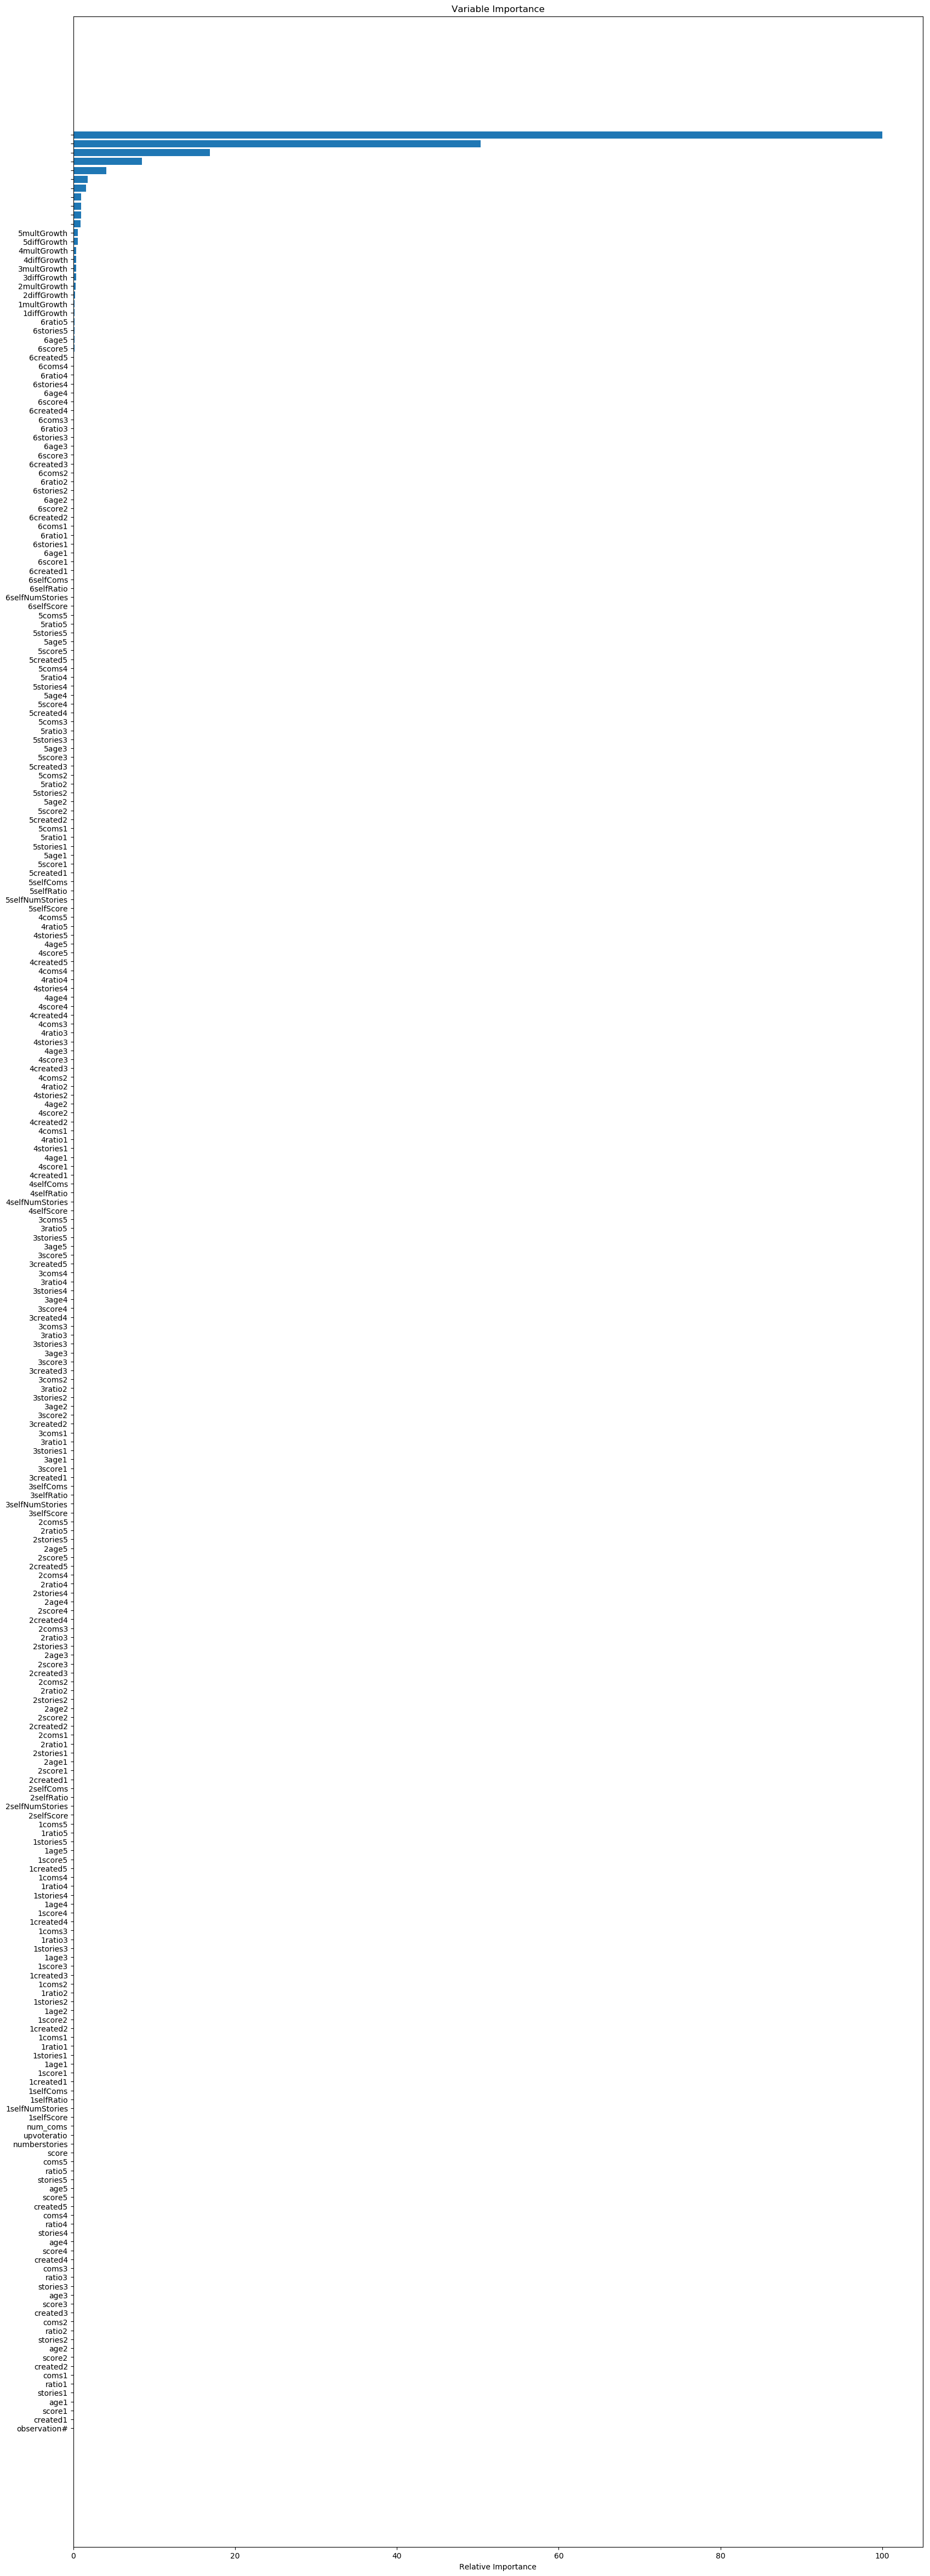

In [59]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20, 60))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


### Our dummies capture almost the entire thing!

In [60]:
clf.score(X_test, y_test)

0.6624355930771206

### Much better than our R^2 of the basic regression, but again, it does not really tell us about the "quality" of our misses. Where is our machine failing? Is it predicting too high? Too low?

## Fitted General Test

Not a perfect metric by any means, but this allows us to get a sense of where our misses are happening. We simulate a psuedo-classification problem. Setting our threshhold, and then flagging where our machine matched above the threshold and below the threshold. Essentially simulating type-1 and type-2 errors. The logic is, if our machine says 8000 votes, and the actual 6000, that's better than if our machine says 2000 and the actual is a 100. Even though the latter has less of an absolute difference. Perhaps a custom loss function in the future could help us...

In [55]:
import seaborn as sns
plt.style.use("fivethirtyeight")

def fittedGeneralTest(reg, thresh, trainX, trainy, testX, testy):
    print("The Score is: ", reg.score(testX, testy))
    a = np.where(testy > thresh)[0].tolist()
    preds = reg.predict(testX)
    p = np.where(preds > thresh)[0].tolist()
    print(a)
    print(p)
    c = 0
    i = 0
    m = 0
    for e in p:
        if e not in a:
            print("Incorrect Prediction", e, "actual score:", testy.tolist()[e], "predicted score:", preds.tolist()[e])
            i += 1
        else:
            print("Correct Prediction", e ,"actual score:", testy.tolist()[e], "predicted score:", preds.tolist()[e])
            c += 1
    for e in a:
        if e not in p:
            print("Missed Prediction", e, "actual score:", testy.tolist()[e], "predicted score:", preds.tolist()[e])
            m += 1
    print("Correct:", c)
    print("Inorrect:", i)
    print("Missed:", m)
    dat = [c, i, m]
    return(testy, preds, dat)

In [56]:
x = fittedGeneralTest(clf, 2000, X_train, y_train, X_test, y_test)[2]

The Score is:  0.6712767651157012
[66, 228, 333, 388, 524, 540, 669, 677, 732, 754, 863, 865, 888, 1161, 1215, 1655, 1673, 1787, 1823, 1872, 1900, 1928, 2087, 2199, 2343, 2490, 2522, 2584, 2623, 2848, 2852, 2942, 2952, 3024, 3085, 3105, 3302, 3476, 3592, 3629, 3687, 3975, 4005, 4014, 4381, 4485, 4675, 4678, 4732, 4832, 4907, 4918, 5054, 5136, 5283, 5357, 5730, 5761, 5894, 5914, 6084, 6277, 6411, 6467, 6508, 6606, 6787, 6796, 6803, 6965, 6974, 7126, 7187, 7217, 7299, 7328, 7384, 7433, 7599, 7683, 7809, 7838, 7880, 8083, 8334, 8354, 8490, 8811, 9193, 9356, 9449]
[109, 133, 237, 388, 524, 665, 669, 677, 754, 781, 865, 888, 1107, 1168, 1193, 1215, 1444, 1597, 1655, 1673, 1787, 1823, 1877, 1900, 1928, 2087, 2151, 2335, 2343, 2440, 2473, 2490, 2522, 2584, 2652, 2739, 2848, 2852, 2942, 2952, 3024, 3065, 3085, 3302, 3476, 3536, 3633, 3687, 3703, 3868, 3886, 3975, 4005, 4014, 4264, 4354, 4675, 4732, 4832, 4842, 4910, 4918, 4946, 4967, 5054, 5136, 5161, 5238, 5283, 5357, 5445, 5489, 5730, 5761, 

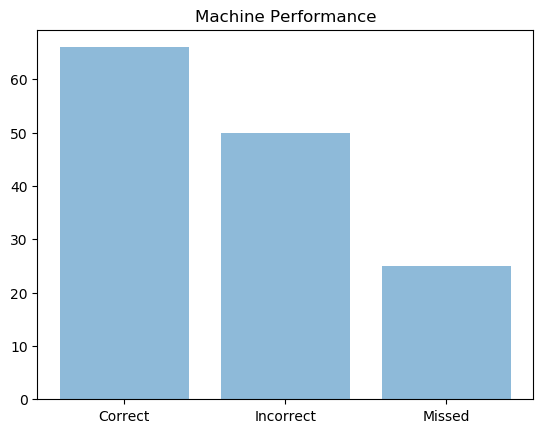

In [57]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Correct', 'Incorrect', 'Missed')
y_pos = np.arange(len(objects))
performance = x

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Machine Performance')

plt.show()

## We have a lot of corrects, but a lot of incorrects as well, though missed is fairly low. What if we try none of our auxillaries, how do we perform then? 

Let's make a pipeline function that combines all the stuff we did above and gives us the graphs we need

In [34]:
def regTestPipeline(X, y, machine):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=829)
    clf = machine
    clf.fit(X_train, y_train)

    test_score = np.zeros((machine.n_estimators,), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(20, 60))
    plt.subplot(1, 1, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    print("The score is", clf.score(X_test, y_test))
    x = fittedGeneralTest(clf, 2000, X_train, y_train, X_test, y_test)
    return x

In [35]:
results = {}

In [ ]:
results["baseAllExtra"] = regTestPipeline(X,y, clf)

In [22]:
obj = init(6, 2000, growths = False, feats = False, days = False, opp = 0)
X = obj[0]
y = obj[1]

In [ ]:
params = {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}
clf = ensemble.GradientBoostingRegressor(**params)
results["baseNoExtra"] = regTestPipeline(X,y, clf)

## Let's set up a grid search

We will set up various different data - regression pairs and store the results in our results dictionary

In [ ]:
grid = {}
a = init(6, 2000, growths = False, feats = False, days = False, opp = 0)
b = init(6, 2000, growths = True, feats = True, days = True, opp = 12)
c = init(6, 2000, growths = True, opp = 0)
grid["baseNoExtra"] = [a, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseAllExtra"] = [b, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["onlyGrowths"] = [c, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseAllExtra2000"] = [b, {'n_estimators': 2000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseAllExtraDepth3"] = [b, {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseAllExtraDepth1"] = [b, {'n_estimators': 1000, 'max_depth': 1, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseAllExtraSS5"] = [b, {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseAllExtraSS2"] = [b, {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseOnlyFeats"] = [init(6, 2000, growths = False, feats = True, days = False, opp = 0), {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseAllExtraHours"] = [init(6, 2000, growths = True, feats = True, days = True, hours = True, opp = 0), {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["baseOnlyDays"] = [init(6, 2000, growths = False, feats = False, days = True, opp = 0), {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}]
grid["LADbaseNoExtra"] = [a, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'lad', 'verbose': 1}]
grid["LADbaseAllExtra"] = [b, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'lad', 'verbose': 1}]
grid["LADonlyGrowths"] = [c, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,'learning_rate': 0.01, 'loss': 'lad', 'verbose': 1}]
grid["HUBbaseNoExtra"] = [a, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'huber', 'verbose': 1}]
grid["HUBbaseAllExtra"] = [b, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'huber', 'verbose': 1}]
grid["HUBonlyGrowths"] = [c, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,'learning_rate': 0.01, 'loss': 'huber', 'verbose': 1}]
grid["q9baseNoExtra"] = [a, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.9,  'verbose': 1}]
grid["q9baseAllExtra"] = [b, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.9,  'verbose': 1}]
grid["q9onlyGrowths"] = [c, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.9, 'verbose': 1}]
grid["q99baseNoExtra"] = [a, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.99,  'verbose': 1}]
grid["q99baseAllExtra"] = [b, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.99,  'verbose': 1}]
grid["q99onlyGrowths"] = [c, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.99, 'verbose': 1}]
grid["q8baseNoExtra"] = [a, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.8,  'verbose': 1}]
grid["q8baseAllExtra"] = [b, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.8,  'verbose': 1}]
grid["q8onlyGrowths"] = [c, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.8, 'verbose': 1}]
grid["q70baseNoExtra"] = [a, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.70,  'verbose': 1}]
grid["q70baseAllExtra"] = [b, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3, 'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.70,  'verbose': 1}]
grid["q70onlyGrowths"] = [c, {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 3,'learning_rate': 0.01, 'loss': 'quantile', 'alpha': 0.70, 'verbose': 1}]

In [ ]:
grid.pop("baseAllExtra2000")

In [ ]:
for key, val in grid.items():
    X = val[0][0]
    y = val[0][1]
    clf = ensemble.GradientBoostingRegressor(**val[1])
    results[key] = regTestPipeline(X,y, clf)

In [51]:
for key,val in results.items():
    print(key, val[2])
    print(key, val[2][0]/(val[2][0] + val[2][1] + val[2][2]))

baseNoExtra [66, 54, 25]
baseNoExtra 0.45517241379310347
baseAllExtra [65, 52, 26]
baseAllExtra 0.45454545454545453
onlyGrowths [64, 51, 27]
onlyGrowths 0.4507042253521127
baseAllExtraDepth3 [64, 46, 27]
baseAllExtraDepth3 0.46715328467153283
baseAllExtraDepth1 [66, 63, 25]
baseAllExtraDepth1 0.42857142857142855
baseAllExtraSS5 [64, 47, 27]
baseAllExtraSS5 0.463768115942029
baseAllExtraSS2 [64, 46, 27]
baseAllExtraSS2 0.46715328467153283
baseOnlyFeats [66, 53, 25]
baseOnlyFeats 0.4583333333333333
baseAllExtraHours [65, 54, 26]
baseAllExtraHours 0.4482758620689655
baseOnlyDays [66, 54, 25]
baseOnlyDays 0.45517241379310347
LADbaseNoExtra [20, 2, 71]
LADbaseNoExtra 0.21505376344086022
LADbaseAllExtra [26, 2, 65]
LADbaseAllExtra 0.27956989247311825
LADonlyGrowths [26, 2, 65]
LADonlyGrowths 0.27956989247311825
HUBbaseNoExtra [36, 6, 55]
HUBbaseNoExtra 0.3711340206185567
HUBbaseAllExtra [30, 3, 61]
HUBbaseAllExtra 0.3191489361702128
HUBonlyGrowths [31, 3, 60]
HUBonlyGrowths 0.329787234042553

## Let's see our results! 

What we did:

* Extra variables: Generally doesn't help that much, though it doesn't hurt. It seems our machine is able to extract the information from our base columns just fine
* Different losses:
    * Huber: doesn't help us
    * Lad: doesn't help us
    * Quantile: Now this one is interesting
        * High percentile means we get everything correct, but lots of incorrects, and almost no missed
        * Perhaps some ensemble regressor which could reclassify ones our machine marks as above 2000 could work
* sample_split: It seems both 2 and 5 do better than 3
* Depth: More depth seems to help
   

In [ ]:
params = {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls', 'verbose': 1}
clf = ensemble.GradientBoostingRegressor(**params)
results["baseNoExtra"] = regTestPipeline(X,y, clf)

### Increasing depths doesn't seem to do too much. 

We seem to have hit a wall on the gradient boosting regressor. The quantile ensemble is the only idea we have, but let's shelf that for now. How about turning it into a classification problem

## Classification Problem

In [64]:
obj = init(6, 2000, growths = True, feats = True, days = True, opp = 13, clas = True)

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Viral Shanker\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Viral Shanker\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [65]:
X = obj[0]
y = obj[1]
obj[1]

0        0
1        0
2        0
3        0
4        0
        ..
38016    0
38017    0
38018    0
38019    0
38020    0
Name: success, Length: 38021, dtype: int64